In [1]:
import numpy as np 
import os
import matplotlib.pyplot as plt
from matplotlib import transforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io import fits 
from astropy.convolution import convolve, Gaussian2DKernel
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from astropy.visualization import ImageNormalize, ZScaleInterval, LinearStretch

In [2]:
#Set the cosmology to use and the redshift. 
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
z = 2.099

In [3]:
base_fname = "../../Calculations/SKIRTOR/2D_maps/bHDPol_mrn77_tor_oa60_con_oa30-tauV1_i75"
I = fits.open(base_fname+"_total.fits")
Q = fits.open(base_fname+"_stokesQ.fits")
U = fits.open(base_fname+"_stokesU.fits")

In [24]:
P = (Q[0].data**2+U[0].data**2)**0.5/I[0].data
Chi = np.arctan2(U[0].data, Q[0].data)

/var/folders/p7/drxzchtj4yb641v79lt0tjyh0000gn/T/ipykernel_35421/3250335174.py:1: RuntimeWarning: invalid value encountered in divide
  P = (Q[0].data**2+U[0].data**2)**0.5/I[0].data


In [5]:
#Get the model file to read the wavelength. 
wave = np.loadtxt("../../Calculations/SKIRTOR/models/bHDPol_mrn77_tor_oa60_con_oa30-tauV1_i75_sed.dat", usecols=[0])
wave = wave * u.micron

In [6]:
#Find the closest the center of the R-band effective wavelength of 6500. 
wave_targ_FORS2 = 6500*u.AA / (1+z)
k_FORS2 = np.argmin(np.abs(wave-wave_targ_FORS2))

#Also the closest to the F555W value
wave_targ_F555W = 5550*u.AA / (1+z)
k_F555W = np.argmin(np.abs(wave-wave_targ_F555W))

print(k_FORS2, k_F555W)

6 4


In [7]:
#Find the worse seeing of the FORS2 observations. 
all_seeing = Table.read("../../Resolved_Polarization_v3/All_seeing_values.txt", format='ascii')
common_seeing = np.max(all_seeing['col3'][all_seeing['col1']=="W0204-0506"])
common_seeing = common_seeing * u.arcsec

In [8]:
#To match the observed size, the image would roughly have to be 20kpc x 20kpc. From there we can figure out the pixel scale and match the PSF sizes. 
ny, nx = I[0].data[k_FORS2].shape 
phys_size_sim = 20*u.kpc
ang_size_sim = (phys_size_sim/cosmo.angular_diameter_distance(z)).to(u.dimensionless_unscaled)*u.rad
pix_scale_sim = ang_size_sim/nx
print(ang_size_sim.to(u.arcsec), pix_scale_sim.to(u.arcsec))

2.4032392572763457 arcsec 0.003998734205118711 arcsec


In [9]:
#Factor for converting between FWHM and sigma. Needed since the Gaussian2DKernel takes dispersions. 
FWHM_to_sigma_factor = 2*(2*np.log(2))**0.5
print(FWHM_to_sigma_factor)

2.3548200450309493


In [10]:
#Convolve with the FORS2 PSF. First, try to read the images. If they do not exist, run the convolution. 
if os.path.exists("I_FORS2.fits"):
    I_FORS2 = fits.getdata("I_FORS2.fits")
    Q_FORS2 = fits.getdata("Q_FORS2.fits")
    U_FORS2 = fits.getdata("U_FORS2.fits")
else:
    #Set the convolution kernel. 
    gauss_kernel = Gaussian2DKernel(int(common_seeing/FWHM_to_sigma_factor/pix_scale_sim))#, x_size=ny, y_size=nx) 

    #Replace the nans with 0 to make convolution easier. 
    I_use = np.where(np.isnan(I[0].data[k_FORS2]), 0., I[0].data[k_FORS2])
    Q_use = np.where(np.isnan(Q[0].data[k_FORS2]), 0., Q[0].data[k_FORS2])
    U_use = np.where(np.isnan(U[0].data[k_FORS2]), 0., U[0].data[k_FORS2])

    #Run convolution 
    I_FORS2 = convolve(I_use, gauss_kernel)
    Q_FORS2 = convolve(Q_use, gauss_kernel)
    U_FORS2 = convolve(U_use, gauss_kernel)

    #Save the convolved images.
    fits.writeto("I_FORS2.fits", I_FORS2)
    fits.writeto("Q_FORS2.fits", Q_FORS2)
    fits.writeto("U_FORS2.fits", U_FORS2)

In [11]:
#Get the polarization fraction and angle files. 
P_FORS2 = (Q_FORS2**2+U_FORS2**2)**0.5 / I_FORS2
Chi_FORS2 = np.arctan2(U_FORS2,Q_FORS2)

In [12]:
#Convolve with the F555W PSF. 
F555W_FWHM = 0.067*u.arcsec
if os.path.exists("I_F555W.fits"):
    I_F555W = fits.getdata("I_F555W.fits")
    Q_F555W = fits.getdata("Q_F555W.fits")
    U_F555W = fits.getdata("U_F555W.fits")
else:
    #Set the convolution kernel. 
    gauss_kernel = Gaussian2DKernel(int(F555W_FWHM/FWHM_to_sigma_factor/pix_scale_sim)) 

    #Replace the nans with 0 to make convolution easier. 
    I_use = np.where(np.isnan(I[0].data[k_F555W]), 0., I[0].data[k_F555W])
    Q_use = np.where(np.isnan(Q[0].data[k_F555W]), 0., Q[0].data[k_F555W])
    U_use = np.where(np.isnan(U[0].data[k_F555W]), 0., U[0].data[k_F555W])

    #Convolve the images. 
    I_F555W = convolve(I_use, gauss_kernel)
    Q_F555W = convolve(Q_use, gauss_kernel)
    U_F555W = convolve(U_use, gauss_kernel)

    #Save the convolved images.
    fits.writeto("I_F555W.fits", I_F555W)
    fits.writeto("Q_F555W.fits", Q_F555W)
    fits.writeto("U_F555W.fits", U_F555W)

In [13]:
#Get the polarization fraction and angle files. 
P_F555W = (Q_F555W**2+U_F555W**2)**0.5 / I_F555W
Chi_F555W = np.arctan2(U_F555W,Q_F555W)

/var/folders/p7/drxzchtj4yb641v79lt0tjyh0000gn/T/ipykernel_35421/3179197512.py:2: RuntimeWarning: invalid value encountered in divide
  P_F555W = (Q_F555W**2+U_F555W**2)**0.5 / I_F555W


{'_vmin': 0.0, '_vmax': 1.0180049905398683e-12, '_clip': False, '_scale': None, 'callbacks': <matplotlib.cbook.CallbackRegistry object at 0x17d9f67d0>, 'stretch': <astropy.visualization.stretch.LinearStretch object at 0x17e3f10d0>, 'interval': <astropy.visualization.interval.ZScaleInterval object at 0x136d2b610>, 'inverse_stretch': <astropy.visualization.stretch.LinearStretch object at 0x14785e510>, 'invalid': -1.0}


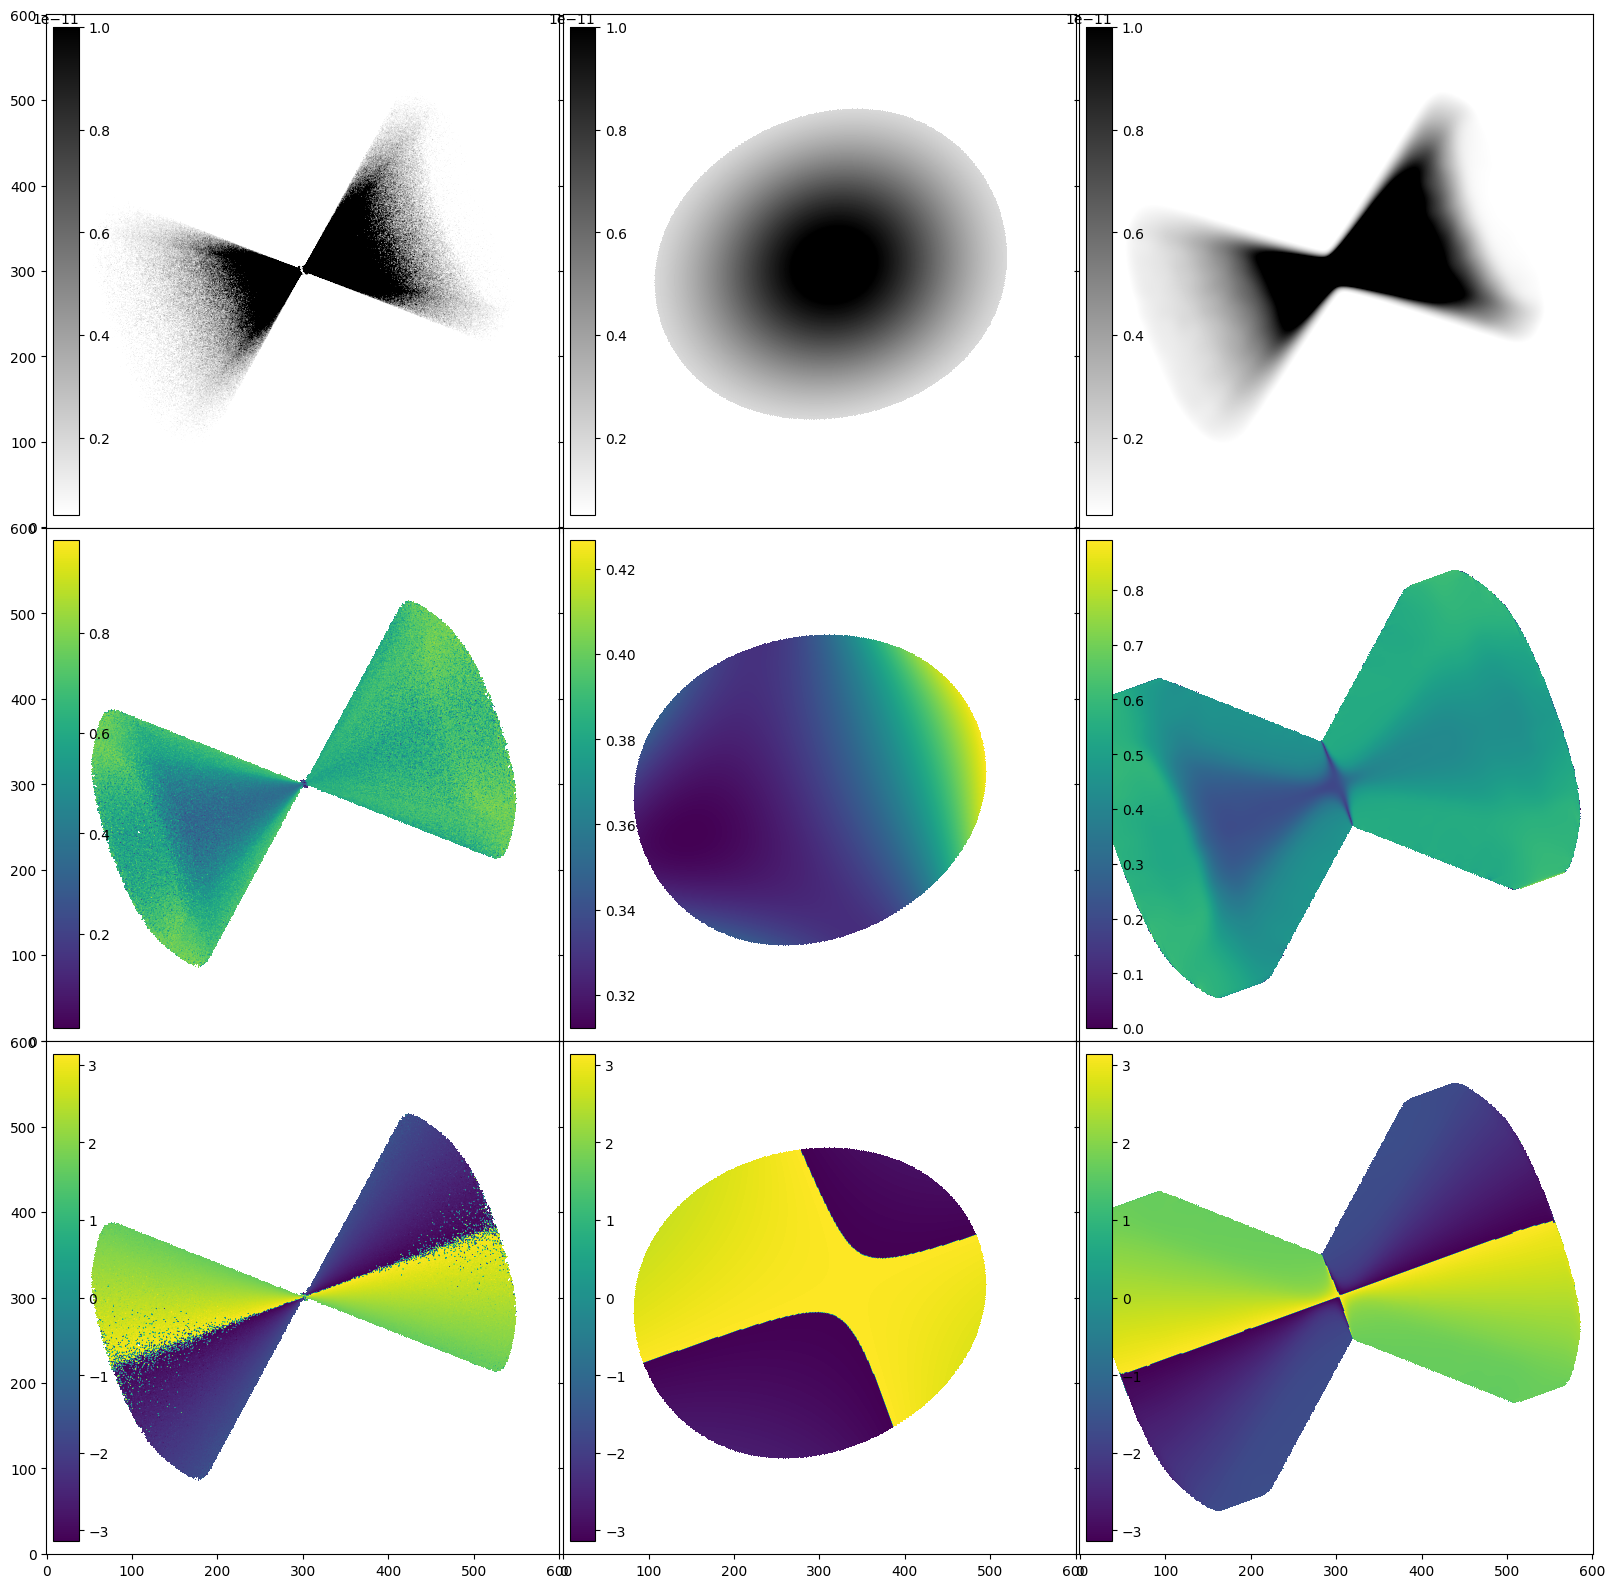

In [27]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,20))
for ax in axs.flatten():
    ax.set_aspect('equal')
plt.subplots_adjust(wspace=0.0,hspace=0.0)

#For FORS2, only use the places where the ratio between the max and the min is about 0.17, the same as is in the real pol image shown in the paper. 
I_FORS2_use = np.where((P_FORS2<1.0) & (I_FORS2>0.17*np.max(I_FORS2)), I_FORS2, np.nan)
P_FORS2_use = np.where((P_FORS2<1.0) & (I_FORS2>0.17*np.max(I_FORS2)), P_FORS2, np.nan)
Chi_FORS2_use = np.where((P_FORS2<1.0) & (I_FORS2>0.17*np.max(I_FORS2)), Chi_FORS2, np.nan)

norm = ImageNormalize(I[0].data[k_FORS2], stretch=LinearStretch(), interval=ZScaleInterval())
print(norm.__dict__)
for k, Iim in enumerate([I[0].data[k_FORS2], I_FORS2_use, I_F555W]):
    tr = transforms.Affine2D().rotate_deg_around(Iim.shape[1]/2., Iim.shape[0]/2., -70)
    cb = axs[0,k].imshow(Iim, origin='lower', transform=tr + axs[0,k].transData, cmap='gray_r', vmin=5.e-13, vmax=1e-11)#, norm=norm)
    cbaxes = inset_axes(axs[0,k], width="5%", height="95%",loc='center left')
    fig.colorbar(cb, cax=cbaxes, orientation='vertical')

Pims = [P[k_FORS2], P_FORS2_use, P_F555W]
for k, Pim in enumerate(Pims):
    tr = transforms.Affine2D().rotate_deg_around(Pim.shape[1]/2., Pim.shape[0]/2., -70 + 180)
    Pim_use = np.where((Pim<=1.0) & (Pim>=0.0), Pim, np.nan)
    cb = axs[1,k].imshow(Pim_use, origin='lower', transform=tr + axs[1,k].transData)#, vmin=0., vmax=1.)
    cbaxes = inset_axes(axs[1,k], width="5%", height="95%",loc='center left')
    fig.colorbar(cb, cax=cbaxes, orientation='vertical')

for k, Cim in enumerate([Chi[k_FORS2], Chi_FORS2_use, Chi_F555W]):
    tr = transforms.Affine2D().rotate_deg_around(Cim.shape[1]/2., Pim.shape[0]/2., -70 + 180)
    Cim_use = np.where((Pims[k]<=1.0) & (Pims[k]>=0.0), Cim, np.nan)
    cb = axs[2,k].imshow(Cim_use, origin='lower', transform=tr + axs[2,k].transData)#, vmin=0., vmax=1.)
    cbaxes = inset_axes(axs[2,k], width="5%", height="95%",loc='center left')
    fig.colorbar(cb, cax=cbaxes, orientation='vertical')


plt.show()